In [35]:
%matplotlib widget

In [36]:
import xtrack as xt

import matplotlib.pyplot as plt

In [37]:
line = xt.Line.from_json('../../xtrack/examples/fcc_ee_solenoid/fccee_z_with_sol_corrected.json')

Loading line from dict:   0%|          | 0/79096 [00:00<?, ?it/s]

Done loading line from dict.           


In [38]:
line.cycle('ip.1')

tw_no_rad = line.twiss(method='4d')
line.configure_radiation(model='mean')
tt = line.get_table(attr=True)

line.vars['on_corr_ip.1'] = 1
line.vars['on_sol_ip.1'] = 1


# # Radiation only in solenoid
# ttmult = tt.rows[tt.element_type == 'Multipole']
# for nn in ttmult.name:
#     line[nn].radiation_flag=0

# RF on
line.vars['voltca1'] = line.vv['voltca1_ref']
line.vars['voltca2'] = line.vv['voltca2_ref']
line.compensate_radiation_energy_loss()
tw = line.twiss()

Found suitable prebuilt kernel `default_xcoll`.
Found suitable prebuilt kernel `default_xcoll_frozen_energy`.
Compensating energy loss.
Found suitable prebuilt kernel `default_xcoll_frozen_longitudinal`.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Share energy loss among cavities (repeat until energy loss is zero)
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Energy loss: 39513501.521 eV             
Energy loss: 16706.143 eV             
Energy loss: 7.073 eV             
Energy loss: 0.003 eV             

  - Set delta_taper
  - Restore cavity voltage and frequency. Set cavity lag
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [39]:
tw = line.twiss(eneloss_and_damping=True)

In [40]:
1/tw.damping_constants_turns

array([2306.42915006, 2306.41959416, 1153.20463041])

In [41]:
tw.partition_numbers

array([1.00028922, 1.00029337, 2.0005957 ])

In [42]:
tw.partition_numbers.sum()

4.001178291408177

In [43]:
tw.c_minus

4.972446964547997e-20

In [45]:
tw.eq_gemitt_x

7.092616358810796e-10

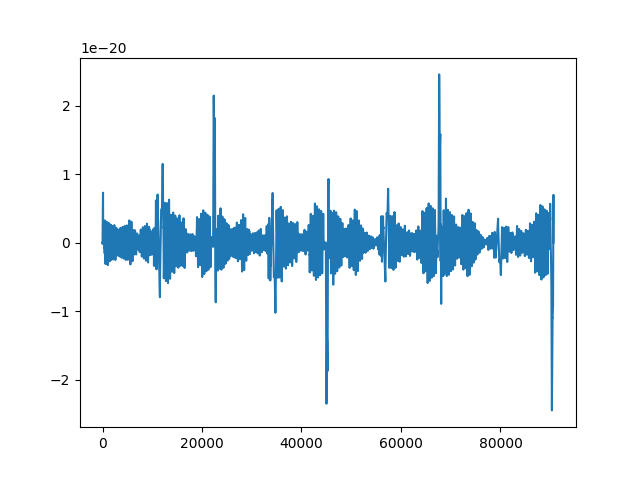

In [47]:
plt.figure()
plt.plot(tw.s, tw.dy)